In [1]:
from helpers import math_helper
from sensors.activpal import *
from utils import read_functions
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import statistics
import os

import matplotlib.pyplot as plt

Adnan Akbas
# Feature Extraction

In [2]:
activpal = Activpal()

features_columns = ['standard_deviation_x', 'mean_x', 'standard_deviation_y', 'mean_y','standard_deviation_z', 'mean_z', 'activiteit']

activity_columns = ['activity_walking', 'activity_running', 'activity_jumping', 'activity_standing', 'activity_traplopen', 'activity_sitten']
#activity_columns = ['cycling_light','cycling_hard', 'activity_walking', 'activity_running', 'activity_jumping', 'activity_standing', 'activity_traplopen', 'activity_sitten']
#activity_columns = ['activity_walking', 'activity_running', 'activity_standing', 'activity_sitten']

activities = ['lopen', 'rennen', 'springen', 'staan', 'traplopen', 'zitten']
#activities = ['fietsen licht', 'fietsen zwaar', 'lopen', 'rennen', 'springen', 'staan', 'traplopen', 'zitten']
#activities = ['lopen', 'rennen', 'staan', 'zitten']

test_users = ['BMR002', 'BMR004', 'BMR008']
segment_size = 9.4

In [3]:
def extract_features_from_correspondent(correspondent):
    features_df = pd.DataFrame(columns=features_columns, index=pd.to_datetime([]))

    # Getting dataset for a correspodent
    activities_df = read_functions.read_activities(correspondent)

    for activity_name in activities:
        activity = activities_df.loc[activity_name]
        if not activity.empty:
            start_time = activity.start
            stop_time = activity.stop
            activpal_df = activpal.read_data(correspondent, start_time, stop_time)

            # denormalizing dataset
            activpal_df['x'] = math_helper.convert_value_to_g(activpal_df['pal_accX'])
            activpal_df['y'] = math_helper.convert_value_to_g(activpal_df['pal_accY'])
            activpal_df['z'] = math_helper.convert_value_to_g(activpal_df['pal_accZ'])

            date_range = pd.date_range(start_time, stop_time, freq=str(segment_size) + 'S')
            
            for time in date_range:
                segment_time = time + pd.DateOffset(seconds=segment_size)
                activpal_segment = activpal_df[(activpal_df.index >= time) & (activpal_df.index <= segment_time)]

                stdev_x =  statistics.stdev(activpal_segment['x']) if len(activpal_segment['x']) >= 2 else 0
                mean_x = activpal_segment['x'].mean()

                stdev_y =  statistics.stdev(activpal_segment['y']) if len(activpal_segment['y']) >= 2 else 0
                mean_y = activpal_segment['y'].mean()

                stdev_z =  statistics.stdev(activpal_segment['z']) if len(activpal_segment['z']) >= 2 else 0
                mean_z = activpal_segment['z'].mean()  


                features_df.loc[segment_time] = [stdev_x, mean_x, stdev_y, mean_y, stdev_z, mean_z, activity_name]

    return features_df

In [4]:
def extract_features_from_all_correspondents():
    all_features_df = pd.DataFrame(index=pd.to_datetime([]))

    for directory in os.walk('../../data'):
        if directory[0] == '../../data':
            for respDirect in directory[1]:
                if respDirect not in ['output', 'throughput', 'Test data','.ipynb_checkpoints', 'BMR035', 'BMR100', 'BMR051', 'BMR027']:
                  #  if respDirect not in test_users:
                    print("Extracting " + respDirect)
                    features_df = extract_features_from_correspondent(respDirect)
                    all_features_df = pd.concat([all_features_df, features_df])

    print("Done extracting features")

    return all_features_df

In [5]:
features_dataset = extract_features_from_all_correspondents()

Extracting BMR099
Extracting BMR025
Extracting BMR060
Extracting BMR012
Extracting BMR030
Extracting BMR044
Extracting BMR043
Extracting BMR004
Extracting BMR011
Extracting BMR098
Extracting BMR034
Extracting BMR014
Extracting BMR036
Extracting BMR052
Extracting BMR002
Extracting BMR031
Extracting BMR097
Extracting BMR008
Extracting BMR015
Extracting BMR033
Extracting BMR064
Extracting BMR055
Extracting BMR041
Extracting BMR053
Extracting BMR042
Extracting BMR018
Extracting BMR058
Extracting BMR040
Extracting BMR032
Done extracting features


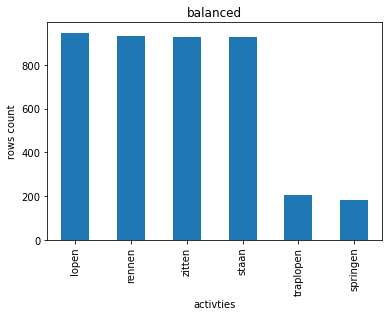

In [6]:
features_dataset['activiteit'].value_counts().plot.bar(ylabel='rows count',xlabel='activties',title='balanced')

# model preperation

In [7]:
features_dataset[activity_columns] = 0

features_dataset.loc[(features_dataset['activiteit'] == 'lopen'), 'activity_walking'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'rennen'), 'activity_running'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'springen'), 'activity_jumping'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'staan'), 'activity_standing'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'traplopen'), 'activity_traplopen'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'zitten'), 'activity_sitten'] = 1
#features_dataset.loc[(features_dataset['activiteit'] == 'fietsen licht'), 'cycling_light'] = 1
#features_dataset.loc[(features_dataset['activiteit'] == 'fietsen zwaar'), 'cycling_hard'] = 1



features_dataset.drop('activiteit', axis=1, inplace=True)
features_dataset.dropna(how='any', inplace=True)

features_dataset.head()

,standard_deviation_x,mean_x,standard_deviation_y,mean_y,standard_deviation_z,mean_z,activity_walking,activity_running,activity_jumping,activity_standing,activity_traplopen,activity_sitten
2019-09-12 10:59:00.400,0.378517,-1.036474,0.257205,0.031408,0.450403,0.179331,1,0,0,0,0,0
2019-09-12 10:59:09.800,0.457929,-1.053276,0.375039,0.026342,0.575255,0.167258,1,0,0,0,0,0
2019-09-12 10:59:19.200,0.510900,-1.023472,0.332070,0.039598,0.576759,0.159659,1,0,0,0,0,0
2019-09-12 10:59:28.600,0.504993,-1.044326,0.352168,0.042806,0.535771,0.170550,1,0,0,0,0,0
2019-09-12 10:59:38.000,0.518234,-1.026765,0.403235,0.027018,0.580535,0.139986,1,0,0,0,0,0


## Preparing feature dataset for learning
### Splitting in x and y

In [8]:
x = features_dataset[features_columns[:-1]]
y = features_dataset[activity_columns]
train_x, valid_x, train_y, valid_y = train_test_split(x,y, test_size=0.2, random_state=23, stratify=y)

train_x.head()

,standard_deviation_x,mean_x,standard_deviation_y,mean_y,standard_deviation_z,mean_z
2019-10-11 13:00:13.200,0.027560,-1.091185,0.090588,0.035292,0.068144,0.137369
2019-09-30 15:46:08.600,0.070672,-1.060199,0.170202,0.103934,0.169147,0.182118
2019-10-08 14:47:08.400,0.000000,0.158730,0.000000,-0.206349,0.000000,1.111111
2019-09-30 14:14:44.000,0.394894,-1.031915,0.255272,0.125633,0.359886,0.191067
2019-10-10 15:38:00.600,0.478484,-1.077014,0.306276,0.137398,0.516153,0.093726


In [9]:
train_y.head()

,activity_walking,activity_running,activity_jumping,activity_standing,activity_traplopen,activity_sitten
2019-10-11 13:00:13.200,0,0,0,1,0,0
2019-09-30 15:46:08.600,0,0,0,1,0,0
2019-10-08 14:47:08.400,0,0,0,0,0,1
2019-09-30 14:14:44.000,1,0,0,0,0,0
2019-10-10 15:38:00.600,1,0,0,0,0,0


# Random tree forest

In [72]:
ftc = RandomForestClassifier(n_estimators=179, random_state=0)
ftc.fit(train_x, train_y)

RandomForestClassifier(n_estimators=179, random_state=0)

## Testing and results

In [73]:
prediction_y = ftc.predict(valid_x)

### Result

#### Accuracy

In [76]:
accuracy_score(valid_y, prediction_y, normalize=True)

0.9503030303030303

#### Classification report 

In [77]:
print(classification_report(valid_y,prediction_y, target_names=activity_columns, zero_division=0))

                    precision    recall  f1-score   support

  activity_walking       0.93      0.97      0.95       189
  activity_running       0.99      0.96      0.98       187
  activity_jumping       0.96      0.59      0.73        37
 activity_standing       0.94      0.99      0.97       186
activity_traplopen       0.97      0.76      0.85        41
   activity_sitten       0.99      0.98      0.99       185

         micro avg       0.96      0.95      0.96       825
         macro avg       0.96      0.88      0.91       825
      weighted avg       0.96      0.95      0.95       825
       samples avg       0.95      0.95      0.95       825



### Confusion matrix

Text(69.0, 0.5, 'true label')

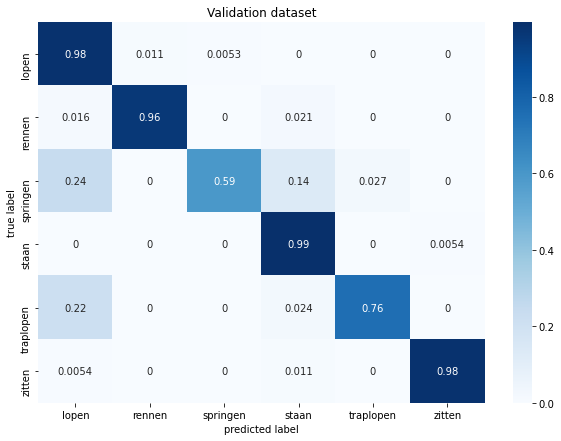

In [78]:
import seaborn as sn

#confusion_matrix(valid_y, prediction_y)
cm = confusion_matrix(valid_y.values.argmax(axis=1), prediction_y.argmax(axis=1), normalize='true')

df_cm = pd.DataFrame(cm, index=activities, columns=activities)
df_cm.head()
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')

plt.title("Validation dataset")
plt.xlabel("predicted label")
plt.ylabel("true label")

# Result Summary

Random seed: 23
n_estimators: 20


### With balanced dataset
|Features| |
|-----| ----|
| standard_deviation_x| mean_x|
| standard_deviation_y| mean_y|
| standard_deviation_z| mean_z|

| Time range | Accuracy | Precision |  Recall |F1|
| ------ | ------ | ------ | ------ |------- |
| 0.4S  | 93% | 96% | 93% | 95% | 
| 0.8S  | 95% | 97% | 95% | 96% |
| 1.0S  | 95% | 98% | 95% | 96% |
| 1.6S  | 95% | 97% | 95% | 96% |
| 2.0S  | 95% | 97% | 95% | 96% |
| 3.2S  | 96% | 98% | 96% | 97% |
| 4.0S  | 95% | 98% | 95% | 96% |
| 6.4S  | 97% | 98% | 97% | 97% | 
| 8.0S  | 96% | 98% | 96% | 97% |
| 10.0S | 96% | 99% | 96% | 97% |
| 12.8S | 97% | 98% | 97% | 97% |

Best results:

| Time range | Accuracy | Precision |  Recall |F1|
| ------ | ------ | ------ | ------ |------- |
| 6.4S  | 97% | 98% | 97% | 97% | 
| 12.8S | 97% | 98% | 97% | 97% |



## Diagnostics
### Cross validation analysis

In [80]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
import seaborn as sn
from sklearn.model_selection import cross_val_predict

rfc = RandomForestClassifier(n_estimators=179, random_state=0)
pred_y = cross_val_predict(rfc, x, y)

In [81]:
accuracy_scores = cross_val_score(rfc, x, y, scoring='accuracy')
recall_scores = cross_val_score(rfc, x, y , scoring='recall_micro')
precision_scores = cross_val_score(rfc, x, y , scoring='precision_micro')

print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() ))
print("Recall: %0.2f (+/- %0.2f)" % (recall_scores.mean(), recall_scores.std() ))
print("Precision: %0.2f (+/- %0.2f)" % (precision_scores.mean(), precision_scores.std() ))

Accuracy: 0.84 (+/- 0.04)
Recall: 0.84 (+/- 0.04)
Precision: 0.89 (+/- 0.02)


K-fold crossvalidation gives 86% accuracy  on average. This means that our model works pretty well

In [17]:
skf = KFold(n_splits=5, shuffle=True)

accuracy_scores = np.array([])
recall_scores = np.array([])
precision_scores = np.array([])

In [18]:
for train_index, test_index in skf.split(x, y):
    x_train, y_train = x.iloc[train_index], y.iloc[train_index]
    x_test, y_test = x.iloc[test_index], y.iloc[test_index]
    
    rfc = RandomForestClassifier(n_estimators=20, random_state=0)
    rfc.fit(x_train, y_train)
    
    predictions = rfc.predict(x_test)
    
    accuracy_scores  = np.append(accuracy_scores, accuracy_score(y_test, predictions, normalize=True))
    recall_scores    = np.append(recall_scores, recall_score(y_test, predictions, average='micro'))
    precision_scores = np.append(precision_scores, precision_score(y_test, predictions, average='micro'))

In [19]:
accuracy_scores.mean()

0.9308902618417182

In [20]:
recall_scores.mean()

0.9308902618417182

In [21]:
precision_scores.mean()

0.9561694207718183

In [22]:
#grid search cv sklearn

In [68]:
#### Quick analysis
accuracy_scores = []
f1_scores = []
#precision_scores = []

n_estimator_numbers = range(175,300)

for i in n_estimator_numbers:
    rfc_t = RandomForestClassifier(n_estimators=i, random_state=0)
    rfc_t.fit(train_x, train_y)
    
    predictions = rfc_t.predict(valid_x)
    
    accuracy_scores.append(accuracy_score(valid_y, predictions, normalize=True))
    f1_scores.append(f1_score(valid_y, predictions, average='micro' ))
    #precision_scores.append(precision_score(valid_y, predictions, average='micro'))

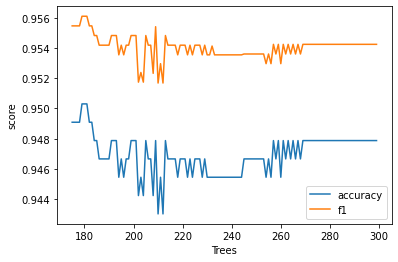

In [69]:
plt.plot(n_estimator_numbers, accuracy_scores, label='accuracy')
plt.plot(n_estimator_numbers, f1_scores, label='f1')

plt.xlabel('Trees')
plt.ylabel('score')
#plt.plot(n_estimator_numbers, precision_scores, label='precision')

plt.legend()

In [70]:
np_accuracy_scores = np.array(accuracy_scores)
np_f1_scores = np.array(f1_scores)

In [71]:
best_accuracy_index = np.argmax(np_accuracy_scores)
best_f1_index = np.argmax(np_f1_scores)

print('accuracy: ', n_estimator_numbers[best_accuracy_index])
print('f1: ', n_estimator_numbers[best_f1_index])

accuracy:  179
f1:  179
